# Evolving cellular automata with genetic algorithms

Preamble: Run the cells below to import the necessary Python packages

<!-- *This notebook created by William Gilpin. Consult the [course website](https://www.wgilpin.com/cphy) for all content and [GitHub repository](https://github.com/williamgilpin/cphy) for raw files and runnable online code.* -->

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/williamgilpin/cphy/blob/main/talks/evolving_cellular_automata.ipynb)

In [5]:
import numpy as np

# Wipe all outputs from this notebook
from IPython.display import Image, clear_output, display
clear_output(True)

# Import local plotting functions and in-notebook display functions
import matplotlib.pyplot as plt
%matplotlib inline


## Import plot settings
import requests
code = requests.get("https://raw.githubusercontent.com/williamgilpin/cphy/main/cphy/template.py", timeout=10).text
exec(code, globals(), globals())


# Gradient-free optimization

Many optimization methods implicitly require the locally-computed gradient of the potential, either explicitly or a finite-difference approximation. This can be computed by hand, approximated by finite differences ($O(N)$ cost, where $N$ is the number of variables), or using automatic differentiation.

When the gradient $\nabla_\theta \mathcal{L}(\theta)$ is not available or is too expensive to compute, we can use a gradient-free optimization methods. This includes many Monte Carlo methods, though this often exploit the existence of small perturbations and weak smoothness of the landscape. For example, the energy of the Ising model is technically a discrete function over discrete spin variables, but in the limit of many spins, a single spin flip produces an arbitrarily small change in energy.

Today, we will consider a case where the gradient is impossible to compute, and there is no smooth variation in the landscape as we change the parameters. As before, we will start by considering a simple 2D fitness landscape, before studying a harder case.

<br><br><br><br>

# Genetic algorithms

A genetic algorithm is a type of evolutionary algorithm that uses a population of candidate solutions to a problem (which can be random combinations of parameters), and then iteratively selects the best solutions from the population using a fitness function. The next generation of candidate solutions will inherit properties these best solutions from the previous generation, and then use the best solutions to create new "offspring" solutions using a combination of mutation and crossover. The offspring solutions are then added to the population, and they usually replace the worst solutions.

The basic structure of a genetic algorithm is as follows:

1. We define a set of candidate solutions to a problem, called the *population*. This can be a set of parameters $\{\boldsymbol{\theta}_m\}_{m=1}^M$ for a population of $M$ candidate solutions $\boldsymbol{\theta}_m \in \mathbb{R}^N$. $N$ is the dimensionality of the search space, while $M$ is a hyperparameter of the algorithm.

2. We evaluate the fitness of each solution in the population using a *fitness function* $\mathcal{L}(\theta) \in \mathbb{R}$. This has a cost of $O(M)$ evaluations per generation.

3. We *select* the best solutions from the population based on their fitness. The next generation will inherit properties these best solutions from the previous generation.

4. We  create new "offspring" solutions using a combination of *mutation* and *crossover*. The former corresponds to a random unary change in the solution $\boldsymbol{\theta}_m' = \boldsymbol{\theta}_m + \boldsymbol{\epsilon}_m$, while the latter corresponds to combining two solutions to create a new one $\boldsymbol{\theta}_m' = f(\boldsymbol{\theta}_m, \boldsymbol{\theta}_k)$, $k \neq m$. The function $f$ is a *crossover* function, which takes two candidate solutions and returns a new one.

5. We add the offspring solutions to the population, and they usually replace the worst solutions.

6. We repeat this process for a given number of generations.

Genetic algorithms are loosely modelled in natural selection, which acts across populations of individuals. Like natural selection, there are general tradeoffs between the population size, the rate at which adaptive changes can spread through the population, and the rate at which the population can explore the search space.

In [80]:
class GeneticAlgorithm:
    """
    A base class for genetic algorithms

    Parameters:
        population_size (int): Number of individuals in the population
        fitness_function (callable): Function that computes the fitness of an individual
        mutation_rate (float): Probability of mutating an individual
        crossover_rate (float): Probability of crossing over two individuals
        fraction_elites (float): Fraction of the population that is copied to the next generation
        random_state (int): Random seed
        verbose (bool): If True, print progress information during evolution
        store_history (bool): If True, store the fitness of the population at each 
            generation
    """

    def __init__(self, 
                 population_size, fitness_function, mutation_rate=0.1, 
                 crossover_rate=0.5, fraction_elites=0.5,
                 random_state=None, verbose=False, store_history=True
        ):
        self.population_size = population_size
        self.fitness_function = fitness_function
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.fraction_elites = fraction_elites

        self.random_state = random_state
        np.random.seed(self.random_state)

        self.verbose = verbose
        self.store_history = store_history
        if self.store_history:
            self.history = list()
            self.fitnesses = list()

        ## Initialize internal variables
        self.population = None
        self.best_fitness = None
        self.best_individual = None


    def initialize(self):
        """Initialize a population of individuals"""
        raise NotImplementedError("This method must be implemented by a subclass")

    def step(self):
        """Perform a single update step of the entire population"""
        raise NotImplementedError("This method must be implemented by a subclass")

    def evolve(self, n_generations):
        """Evolve the population for a given number of generations"""
        self.initialize()
        for i in range(n_generations):
            if self.verbose:
                if i % (n_generations // 20) == 0:
                    print(f'Generation {i} of {n_generations}')
            self.step()
        return self.best_individual

To use genetic algorithms, we need to define a fitness function, which encodes the objective we want to optimize. Here, we will use a familiar low-dimensional fitness function that we saw in the context of gradient descent: the inverse Gaussian function.

(10000, 2)


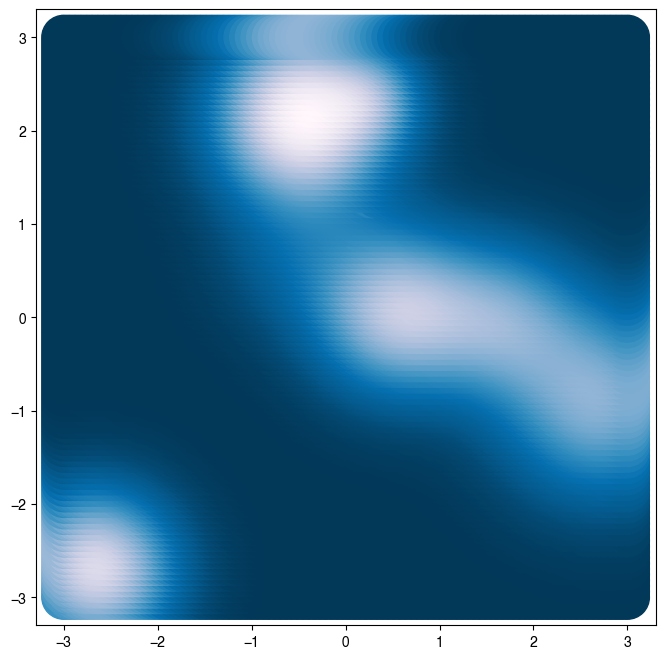

In [6]:

class RandomLossLandscape:
    """
    Creates a random two-dimensional loss landscape with multiple circular gaussian wells

    Args:
        d (int): number of dimensions for the loss landscape
        n_wells (int): number of gaussian wells
        random_state (int): random seed
    
    """

    def __init__(self, d=2, n_wells=3, random_state=None):
        
        # Fix the random seed
        self.random_state = random_state
        np.random.seed(random_state)

        # Select random well locations, widths, and amplitudes
        self.locs = (2 * np.random.uniform(size=(n_wells, d)) - 1) * 3
        self.widths = np.random.rand(n_wells)[None, :]
        self.coeffs = np.random.random(n_wells)
        self.coeffs /= np.sum(self.coeffs) # normalize the amplitudes

    def _gaussian_well(self, X, width=1):
        """
        A single gaussian well centered at 0 with specified width

        Args:
            X (np.ndarray): points at which to compute the gaussian well. This should 
                be of shape (n_batch, n_dim)
            width (float): The width of the gaussian well

        Returns:
            np.ndarray: The value of the gaussian well at points X. The shape of the output
                is (n_batch,)
        """
        return -np.exp(-np.sum((X / width) ** 2, axis=1))

    def _grad_gaussian_well(self, X, width=1):
        return -2 * X / (width ** 2) * self._gaussian_well(X, width)[:, None, :]

    def grad(self, X):
        # Arg shape before summation is (n_batch, n_dim, n_wells)
        return np.sum(
            self.coeffs * self._grad_gaussian_well(X[..., None] - self.locs.T[None, :], self.widths), 
            axis=-1
        )
    
    def loss(self, X):
        """
        Compute the loss landscape at points X

        Args:
            X (np.ndarray): points at which to compute the loss landscape. This should 
                be of shape (n_batch, n_dim)
            width (float): The width of the gaussian wells

        Returns:
            np.ndarray: loss landscape at points X

        Notes:
            The loss landscape is computed as the sum of the individual gaussian wells
            The shape of the argument to np.sum is (n_batch, n_wells)
        """
        return np.sum(
            self._gaussian_well(X[..., None] - self.locs.T[None, :], self.widths) * self.coeffs,
            axis=1
        )

    def __call__(self, X):
        return self.loss(X)

        
# Instantiate a random loss
loss = RandomLossLandscape(random_state=0, n_wells=8)
# loss.plot()
# plt.axis('off')

plt.figure(figsize=(8, 8))

## First we plot the scalar field at high resolution
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
xx, yy = np.meshgrid(x, y)
X = np.array([xx.ravel(), yy.ravel()]).T
print(X.shape)
Z = loss(X) # same as loss.loss(X) because class is callable
plt.scatter(X[:, 0], X[:, 1], c=Z, s=1000)


In [ ]:
# def fitness(x):
#     """A 2D fitness function corresponding to the sum of two Gaussian peaks"""
#     return np.exp(-((x[0] - 0.5)**2 + (x[1] - 0.5)**2) / 0.1**2) + \
#            np.exp(-((x[0] - 0.5)**2 + (x[1] - 0.75)**2) / 0.1**2)

# xx, yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
# xx, yy = xx.ravel(), yy.ravel()

# plt.figure(figsize=(6, 6))
# plt.scatter(xx, yy, c=fitness([xx, yy]), s=10, cmap='viridis')
# plt.axis('off')

fitness = lambda x: -loss(x)

Generation 0 of 100
Generation 5 of 100
Generation 10 of 100
Generation 15 of 100
Generation 20 of 100
Generation 25 of 100
Generation 30 of 100
Generation 35 of 100
Generation 40 of 100
Generation 45 of 100
Generation 50 of 100
Generation 55 of 100
Generation 60 of 100
Generation 65 of 100
Generation 70 of 100
Generation 75 of 100
Generation 80 of 100
Generation 85 of 100
Generation 90 of 100
Generation 95 of 100


(np.float64(-3.3), np.float64(3.3), np.float64(-3.3), np.float64(3.3))

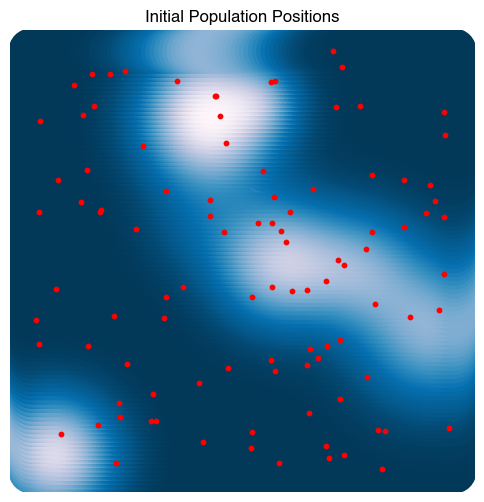

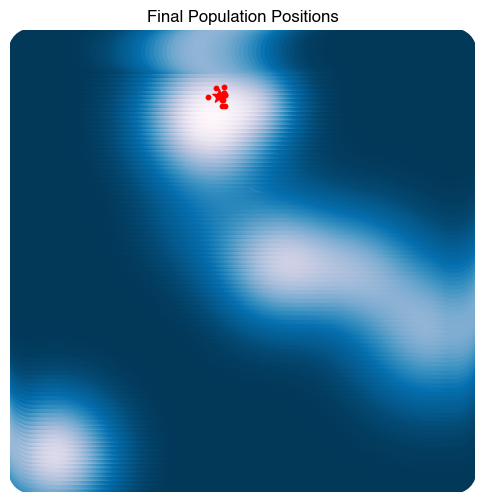

In [25]:
class EvolveLandscape(GeneticAlgorithm):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.population = np.random.rand(self.population_size, 2) * 6 - 3

    def initialize(self):
        """Initialize a population of individuals"""
        self.best_fitness = np.zeros(self.population_size)
        self.best_individual = np.zeros(2)

    def step(self):
        """Perform a single update step of the entire population"""
        # Evaluate the fitness of each individual
        # for i in range(self.population_size):
        #     self.best_fitness[i] = self.fitness_function(self.population[i])


        self.best_fitness = self.fitness_function(self.population)

        # Find the best individual
        self.best_individual = self.population[np.argmax(self.best_fitness)]
        # Store the best fitness
        if self.store_history:
            self.history.append(self.population.copy())
            self.fitnesses.append(self.best_fitness.copy())

        # Create a new population
        new_population = np.zeros_like(self.population)

        # Elite survival: copy the best individuals
        n_elites = int(self.fraction_elites * self.population_size)
        new_population[:n_elites] = self.population[np.argsort(self.best_fitness)][-n_elites:]
        
        ## Fill the rest of the population by crossover
        for i in range(n_elites, self.population_size, 2):

            ## Select two individuals from the current population
            parents = self.population[np.random.choice(self.population_size, 2, replace=False)]

            # Perform crossover
            new_population[i] = parents[0] * (1 - self.crossover_rate) + parents[1] * self.crossover_rate
            new_population[i + 1] = parents[1] * (1 - self.crossover_rate) + parents[0] * self.crossover_rate

            # Mutate the new individuals
            if np.random.rand() < self.mutation_rate:
                new_population[i] += np.random.randn(2) * 0.1
            if np.random.rand() < self.mutation_rate:
                new_population[i + 1] += np.random.randn(2) * 0.1

        ## Replace the old population with the new one
        self.population = new_population

## Create an instance of the genetic algorithm
ga = EvolveLandscape(
    population_size=100, fitness_function=fitness, mutation_rate=0.1, 
    crossover_rate=0.5, fraction_elites=0.5, random_state=0, verbose=True
)

plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], c=Z, s=1000)
plt.scatter(ga.population[:, 0], ga.population[:, 1], c='r', s=10)
plt.title("Initial Population Positions")
plt.axis('off')

# Evolve the population for 100 generations
ga.evolve(100)

plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], c=Z, s=1000)
plt.scatter(ga.best_individual[0], ga.best_individual[1], c='r', s=100, marker='*')
plt.scatter(ga.population[:, 0], ga.population[:, 1], c='r', s=10)
plt.title("Final Population Positions")
plt.axis('off')

Text(0.5, 1.0, 'Trajectories')

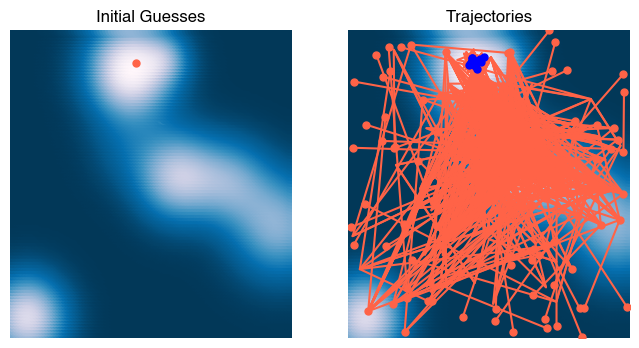

In [28]:
X0 = ga.population[0]
Xs = np.array(ga.history)


plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=Z)
plt.plot(*X0.T, '.')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.axis('off')
plt.title('Initial Guesses')

plt.subplot(1, 2, 2)
plt.scatter(X[:, 0], X[:, 1], c=Z)
plt.plot(Xs[0, :, 0], Xs[0, :, 1], '.');
plt.plot(Xs[:, :, 0], Xs[:, :, 1], '-');
plt.plot(Xs[-1, :, 0], Xs[-1, :, 1], '.b', zorder=10);
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.axis('off')
plt.title('Trajectories')

Text(0, 0.5, 'Fitness')

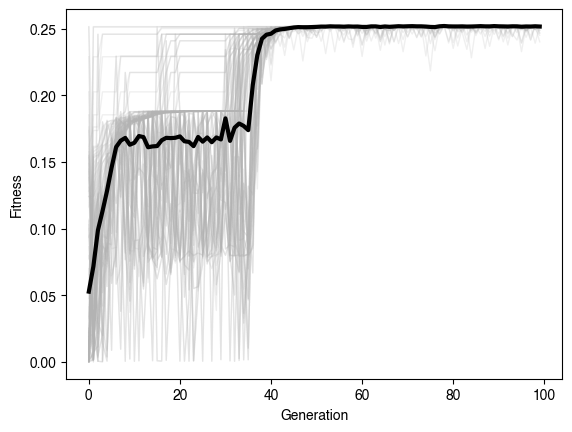

In [29]:
plt.figure()
plt.plot(np.array(ga.fitnesses), color=(0.7, 0.7, 0.7), lw=1, alpha=0.2)
plt.plot(np.mean(np.array(ga.fitnesses), axis=1), 'k', lw=3)
plt.xlabel('Generation')
plt.ylabel('Fitness')


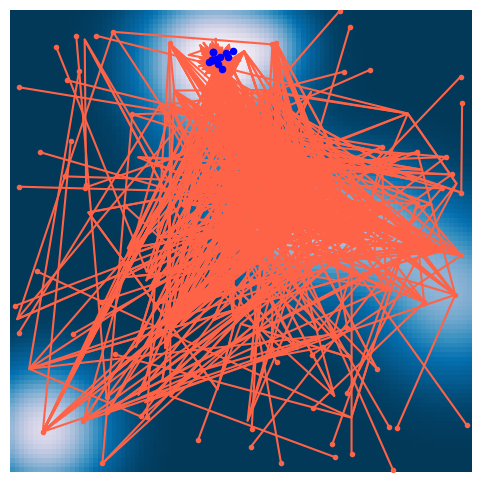

In [31]:
from matplotlib.animation import FuncAnimation
from matplotlib.collections import LineCollection
from IPython.display import HTML

Xs = np.array(ga.history)[::1][:500]

fig, ax = plt.subplots(figsize=(6, 6))
# ax.scatter(X[:, 0], X[:, 1], c=Z, s=14, zorder=0)
plt.imshow(Z.reshape(100, 100), extent=[-3, 3, -3, 3], origin='lower')
ax.plot(Xs[0, :, 0], Xs[0, :, 1], '.', ms=6, linestyle='None', zorder=1)
curr = ax.scatter([], [], s=20, c='b', zorder=3)
trail = LineCollection([], zorder=2)
ax.add_collection(trail)

ax.set_xlim(-3, 3); ax.set_ylim(-3, 3); ax.axis('off')
plt.margins(0, 0); plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

def init():
    curr.set_offsets(np.array([0, 0]))
    trail.set_segments([])
    return (curr, trail)

def update(t):
    # current points
    curr.set_offsets(Xs[t])

    if t > 0:
        segs = []
        # Build one polyline per particle (skip if fewer than 2 points)
        for n in range(Xs.shape[1]):
            path = Xs[:t+1, n, :]  # (k,2)
            if path.shape[0] >= 2:
                segs.append(path)
        trail.set_segments(segs)


    return (curr, trail)

ani = FuncAnimation(fig, update, frames=min(500, Xs.shape[0]),
                    init_func=init, interval=100, blit=True, repeat=True)
html = ani.to_html5_video()                                 # replaces to_jshtml()
HTML(html)

Why did this work? In stochastic gradient descent, we saw that random walks in low dimensions tend to eventually find minima. Thus, trajectories that start in the flat regions of the landscape can gradually wander into valleys of the landscape due to the mutations. However, we expect that this effect is less useful in high dimensions, where random walks tend to move away from the starting point faster. However, we suspect that **recombination** is a more important effect in this system. For two high-fitness parents, the offspring will be located along a line connecting them, which resembles using a gradient-based method.

However, genetic algorithms are most useful when the "space" of parameters does not have a metric structure. In this case, finding an appropriate mutation and recombination operations (that produce offspring with higher fitness than the parents) is a non-trivial problem.

<br><br><br><br><br><br>

# Evolving cellular automata

Recall that cellular automata are dynamical systems that take on discrete values, on a discrete grid, with discrete time steps. Their discrete nature precludes the use of gradient-based methods when analyzing their behavior

Here, we will study a minimal version of influential results that exploring the space of CA with genetic algorithms can be found in [Mitchell et al. 1993](https://arxiv.org/abs/adap-org/9303003) and [Crutchfield & Mitchell 1995](https://www.pnas.org/doi/10.1073/pnas.92.23.10742) 

<img src="https://raw.githubusercontent.com/williamgilpin/cphy/main/resources/crutchfield_mitchell.png" style="max-width:50%; height:auto;">

### Background on one-dimensional CA

Consider one-dimensional cellular automata, which have a much smaller space of possible rulesets than two-dimensional CA like the Game of Life. A one-dimensional CA has a "state" $\mathbf{s}$ given by a binary string, $\mathbf{s}_t = \{0, 1\}^N$ for a lattice with $N$ sites.

We consider the space of first-neighbor rulesets. These are rules that update each position $s_{t, i} \to s_{t+1, i}$ based only on the values of its left and right neighbors, as well as its own value. $s_{t+1, i} = f(s_{t, i-1}, s_{t, i}, s_{t, i+1})$. This is a local CA, similar to how the Game of Life updates each cell based only on its nearest neighbors.

For one-dimensional CA first-neighbor rulesets, there are $2^3 = 8$ possible groups of three adjacent cells. We can think of the CA ruleset as a binary function that maps each of these $8$ possible inputs to either a 0 or 1. Since there are a finite number of inputs and outputs, there are a finite number of possible rulesets $f(s_{t, i-1}, s_{t, i}, s_{t, i+1})$, which is $2^8 = 256$.

The universe of all possible one-dimensional CA rulesets is thus a space containing $256$ possible rulesets. Now, suppose that we want to find the ruleset that satisfies some desired behavior. For instance, we may want to find the ruleset most that produces the most $1$s in the long-time limit. Our fitness function is thus the long-time average number of $1$s in the state,
$$
    \mathcal{L}(\mathbf{s}_t) = \lim_{t \to \infty} \sum_{i=1}^N s_{t, i}
$$
If we wanted to optimize this fitness function, our optimization variable is the CA ruleset itself. This is a discrete variable, and so no gradient information is available. Additionally, evaluating the fitness function requires actually simulating the CA, so it's more involved than a simple function evaluation. In low dimensions, we could just perform a brute-force search over the space of $256$ rulesets: we pick random initial conditions, simulate the CA, and see if it converges to a uniform state.

We start by defining our base class for cellular automata, which should look familiar from the previous notebook.

In [32]:
class CellularAutomaton:
    """
    A base class for cellular automata. Subclasses must implement the step method.

    Parameters
        n (int): The number of cells in the system
        n_states (int): The number of states in the system
        random_state (None or int): The seed for the random number generator. If None,
            the random number generator is not seeded.
        initial_state (None or array): The initial state of the system. If None, a 
            random initial state is used.
        
    """
    def __init__(self, n, n_states, random_state=None, initial_state=None):
        self.n_states = n_states
        self.n = n
        self.random_state = random_state

        np.random.seed(random_state)

        ## The universe is a 2D array of integers
        if initial_state is None:
            self.initial_state = np.random.choice(self.n_states, size=(self.n, self.n))
        else:
            self.initial_state = initial_state
        self.state = self.initial_state

        self.history = [self.state]

    def next_state(self):
        """
        Output the next state of the entire board
        """
        return NotImplementedError

    def simulate(self, n_steps):
        """
        Iterate the dynamics for n_steps, and return the results as an array
        """
        for i in range(n_steps):
            self.state = self.next_state()
            self.history.append(self.state.copy())
        return self.state

## Parameterizing the space of two-dimensional CA

We want to represent the space of *rules* for two-dimensional CA like the Game of Life, which are discrete-valued functions that take in a neighborhood of $9$ cells and return a new value for the center cell

+ We consider only binary cellular automata like Conway's Game of Life, for which a given cell can be either "alive" (1) or "dead" (0). 

+ For a Moore neighborhood CA (nearest neighbors including diagonal), there are $2^9 = 512$ possible input values if we include the center cell.

+ For each input value, there are two possible output values. Therefore, there are $2^{2^9} \approx 10^{154}$ possible rules.

We therefore define a subclass, `ProgrammaticCA`, which takes a ruleset in its constructor and defines the corresponding CA. We saw previously that many common CA may be quickly implemented using 2D convolutions with an appropriate kernel. For our implementation, we define a special convolutional kernel that converts a 3x3 neighborhood into a unique integer between 0 and 511. We then use this integer to index into the ruleset to determine the output value.

Text(0.5, 1.0, 'Final state')

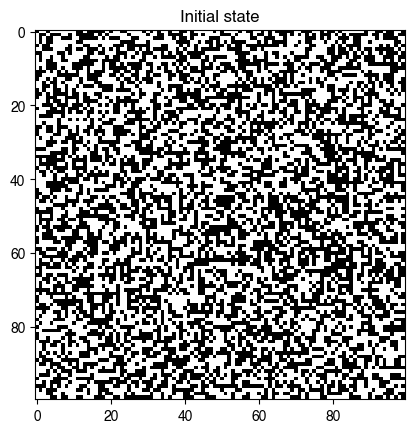

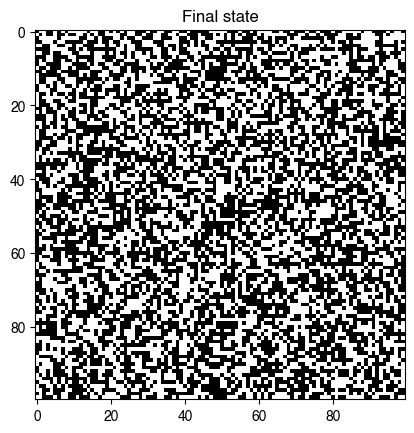

In [46]:
from scipy.signal import convolve2d

class ProgrammaticCA(CellularAutomaton):

    def __init__(self, n, ruleset,  **kwargs):
        k = np.unique(ruleset).size
        super().__init__(n, 2, **kwargs)
        self.ruleset = ruleset

        ## A special convolutional kernel for converting a binary neighborhood 
        ## to an integer
        self.powers = np.reshape(2 ** np.arange(9), (3, 3))

    def next_state(self):

        # Compute the next state
        next_state = np.zeros_like(self.state)
        
        # convolve with periodic boundary conditions
        rule_indices = convolve2d(self.state, self.powers, mode='same', boundary='wrap')

        ## look up the rule for each cell
        next_state = self.ruleset[rule_indices.astype(int)]

        return next_state

# An entire CA can be represented as a single binary integer or hexidecimal code
random_ruleset = np.random.choice(2, size=2**9)

model = ProgrammaticCA(100, random_ruleset, random_state=0)
model.simulate(500)

plt.figure()
plt.imshow(model.initial_state, cmap="gray")
plt.title("Initial state")

plt.figure()
plt.imshow(model.state, cmap="gray")
plt.title("Final state")

## Searching the space of cellular automata with genetic algorithms

We are now ready to define a genetic algorithm that searches the space of cellular automata for interesting behavior.

Our fitness function will encode a desired property of a learned automaton. The automaton itself is specified by a binary string encoding what it assigns to each of the $2^9 = 512$ possible $3 \times 3$ inputs it receives.

A simple choice of fitness function is the variance of the number of live vs dead cells after many steps, in order to encourage discovery of CA that produce long-lived structures. Calculating the fitness function for a given ruleset thus requires initializing a CA with a random initial state, simulating it for a fixed number of steps, and then calculating the final, scalar variance of the final state.

We can also make some modifications to the fitness function to encourage activity, but you can try changing the fitness function to see what happens.

In [126]:

def fitness(trajectory):
    """
    A fitness function that rewards activity (mixtures of on and off cells)

    Args:
        trajectory (array): A 2D array of integers representing the state of the CA at
            each time step of the simulation. Shape is (n_steps, nx, ny)

    Returns:
        float: A fitness score
    """
    final_state = trajectory[-1]            
    timechange = np.sum(np.abs(np.diff(np.array(trajectory), axis=0)))
    timechange /= final_state.size
    return np.max(final_state) - np.min(final_state) - np.std(final_state) - timechange


# def fitness(rulesets, n_size=30, num_steps=100):
#     """
#     A fitness function that activity

#     Args:
#         rulesets (array): An array of rulesets, of shape (B, 256). B is the number
#             of rulesets in the population.

#     Returns:
#         float: A fitness score
#     """
#     fitnesses = []
#     for ruleset in rulesets:
#         model = ProgrammaticCA(n_size, ruleset, random_state=0)
#         model.simulate(num_steps)

#         final_state = model.history[-1]            
#         timechange = np.sum(np.abs(np.diff(np.array(model.history), axis=0)))
#         timechange /= final_state.size
#         fitness_val = np.max(final_state) - np.min(final_state) - np.std(final_state) + timechange
#         fitnesses.append(fitness_val)
#     fitnesses = np.array(fitnesses)
#     return fitnesses

         
    

Our genetic algorithm will contain the following steps:

1. The `initialize` method initializes a population of individuals, which are represented by binary strings describing their rulesets

2. The `step` method loops over each individual in the population and creates a CA with its ruleset. It then runs the CA for a fixed number of time steps and computes the fitness from the trajectory. The fitness is then stored in the `fitnesses` array. Selection is then performed using elitism, crossover, and mutation.

All other methods are deferred to the base class.

Generation 0 of 100
Generation 5 of 100
Generation 10 of 100
Generation 15 of 100
Generation 20 of 100
Generation 25 of 100
Generation 30 of 100
Generation 35 of 100
Generation 40 of 100
Generation 45 of 100
Generation 50 of 100
Generation 55 of 100
Generation 60 of 100
Generation 65 of 100
Generation 70 of 100
Generation 75 of 100
Generation 80 of 100
Generation 85 of 100
Generation 90 of 100
Generation 95 of 100


Text(0, 0.5, 'Fitness')

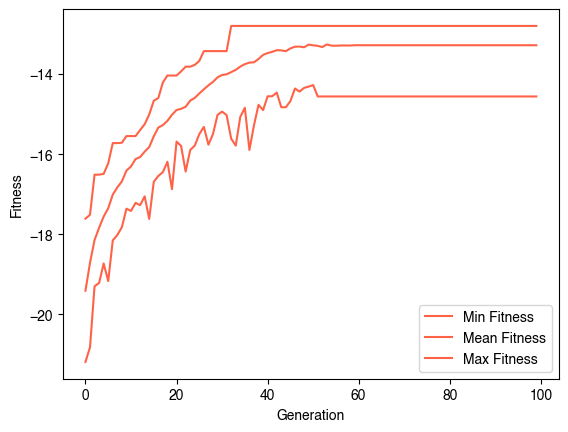

In [127]:
class EvolveCA(GeneticAlgorithm):
    """
    A class for evolving cellular automata rulesets using a genetic algorithm

    Parameters
        n_size (int): The size of the CA spatial lattice
        n_steps (int): The number of CA steps to simulate per generation (the 
            trajectory length)
        **kwargs: Keyword arguments to pass to the GeneticAlgorithm superclass
    """

    def __init__(self, n_size, n_steps, **kwargs):
        super().__init__(**kwargs)
        self.n_size = n_size
        self.n_steps = n_steps

    def initialize(self):
        self.population = np.random.choice(2, size=(self.population_size, 2**9))

    def step(self):
        """Evolve one generation of the population"""
        fitnesses = []
        for ruleset in self.population:
            model = ProgrammaticCA(self.n_size, ruleset, random_state=0)
            model.simulate(self.n_steps)

            fitness_val = self.fitness_function(model.history)
            fitnesses.append(fitness_val)
        fitnesses = np.array(fitnesses).squeeze()

        # fitnesses = self.fitness_function(self.population)

        if self.store_history:
            self.history.append(fitnesses)

        ## Sort population by fitness
        self.population = self.population[np.argsort(fitnesses)]

        ## Create a new generation
        n_elite = int(self.fraction_elites * self.population_size)
        for i in range(self.population_size - n_elite):
            
            ## Crossover two high-performing rulesets
            parent1_ind, parent2_ind = np.random.choice(
                len(self.population[-n_elite:]), size=2, replace=True
            )
            parent1 = self.population[-n_elite:][-parent1_ind]
            parent2 = self.population[-n_elite:][-parent2_ind]
            crossover_point = np.random.randint(len(parent1))

            # crossover_point = 0
            child = np.hstack((parent1[:crossover_point], parent2[crossover_point:]))

            ## Mutate the child at random points
            n_mutate = int(self.mutation_rate * len(child))
            child[np.random.randint(2**9, size=n_mutate)] = np.random.randint(2, size=n_mutate)

            self.population[i] = child
        self.best_individual = self.population[-1]
        self.best_fitness = np.max(fitnesses)

evolver = EvolveCA(40, 40, population_size=50, fitness_function=fitness, random_state=0, verbose=True)
evolver.evolve(100)

plt.figure()
plt.plot(np.min(evolver.history, axis=1), label="Min Fitness")
plt.plot(np.mean(evolver.history, axis=1), label="Mean Fitness")
plt.plot(np.max(evolver.history, axis=1), label="Max Fitness")
plt.legend()
plt.xlabel("Generation")
plt.ylabel("Fitness")

Text(0.5, 1.0, 'Final state')

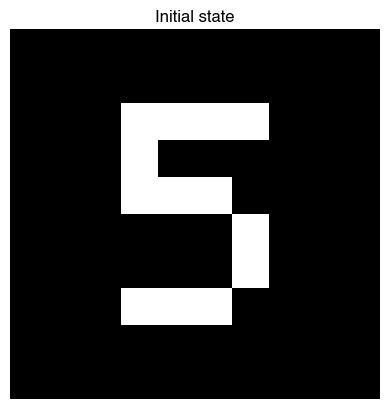

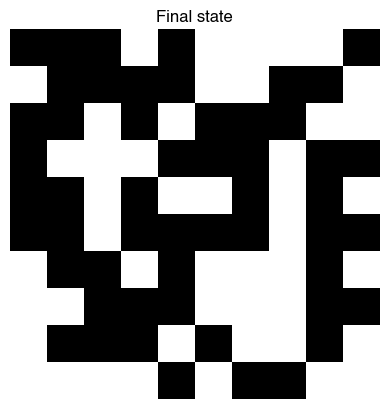

In [128]:
digit_5 = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 1, 1, 1, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
])
# digit_5 = np.logical_not(digit_5)


model = ProgrammaticCA(100, evolver.best_individual, random_state=0, initial_state=digit_5)
model.simulate(30)

plt.figure()
plt.imshow(model.initial_state, cmap="gray")
plt.axis("off")
plt.title("Initial state")


plt.figure()
plt.imshow(model.state, cmap="gray")
plt.axis("off")
plt.title("Final state")


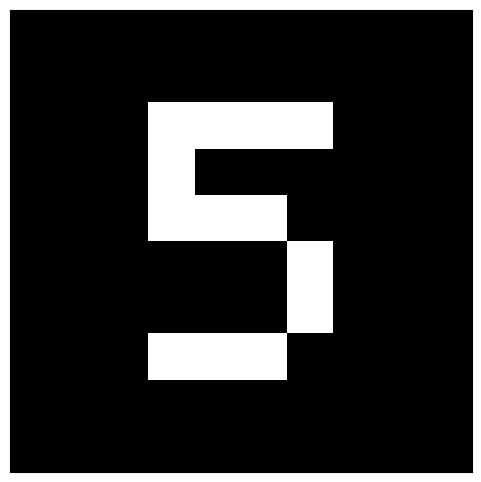

In [129]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Assuming frames is a numpy array with shape (num_frames, height, width)
frames = np.array(model.history).copy() 

fig = plt.figure(figsize=(6, 6))
img = plt.imshow(frames[0], vmin=0, vmax=1, cmap="gray");
plt.xticks([]); plt.yticks([])
# tight margins
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())

def update(frame):
    img.set_array(frame)

ani = FuncAnimation(fig, update, frames=frames, interval=200)
HTML(ani.to_jshtml())

Generation 0 of 100
Generation 5 of 100
Generation 10 of 100
Generation 15 of 100
Generation 20 of 100
Generation 25 of 100
Generation 30 of 100
Generation 35 of 100
Generation 40 of 100
Generation 45 of 100
Generation 50 of 100
Generation 55 of 100
Generation 60 of 100
Generation 65 of 100
Generation 70 of 100
Generation 75 of 100
Generation 80 of 100
Generation 85 of 100
Generation 90 of 100
Generation 95 of 100


Text(0, 0.5, 'Fitness')

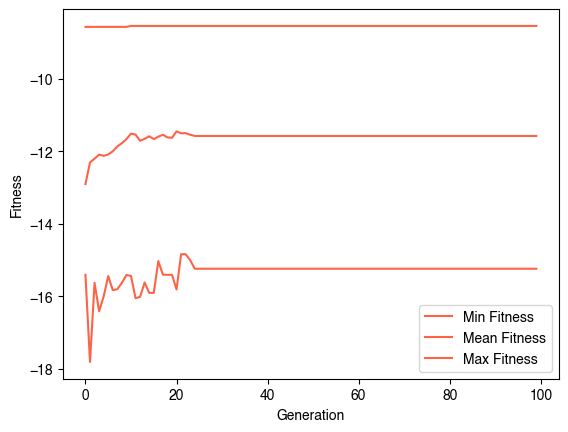

In [156]:

def fitness(trajectory):
    """
    A fitness function that rewards convergence to a target pattern

    Args:
        trajectory (array): A 2D array of integers representing the state of the CA at
            each time step of the simulation. Shape is (n_steps, nx, ny)

    Returns:
        float: A fitness score
    """
    final_state = trajectory[-1]
    not_equal = np.abs(np.sum(final_state) - np.sum(np.ones_like(final_state)) // 2)
    fast_variation = np.sum(np.abs(np.diff(final_state, axis=0))) + np.sum(np.abs(np.diff(final_state, axis=1)))
    return  10*np.std(final_state) - 0.2*fast_variation


evolver = EvolveCA(10, 20, population_size=100, fitness_function=fitness, random_state=0, verbose=True,
                    mutation_rate=0.1, 
                    crossover_rate=0.8, 
                    fraction_elites=0.5
                    )
evolver.evolve(100)

plt.figure()
plt.plot(np.min(evolver.history, axis=1), label="Min Fitness")
plt.plot(np.mean(evolver.history, axis=1), label="Mean Fitness")
plt.plot(np.max(evolver.history, axis=1), label="Max Fitness")
plt.legend()
plt.xlabel("Generation")
plt.ylabel("Fitness")

Generation 0 of 100
Generation 5 of 100
Generation 10 of 100
Generation 15 of 100
Generation 20 of 100
Generation 25 of 100
Generation 30 of 100
Generation 35 of 100
Generation 40 of 100
Generation 45 of 100
Generation 50 of 100
Generation 55 of 100
Generation 60 of 100
Generation 65 of 100
Generation 70 of 100
Generation 75 of 100
Generation 80 of 100
Generation 85 of 100
Generation 90 of 100
Generation 95 of 100


Text(0, 0.5, 'Fitness')

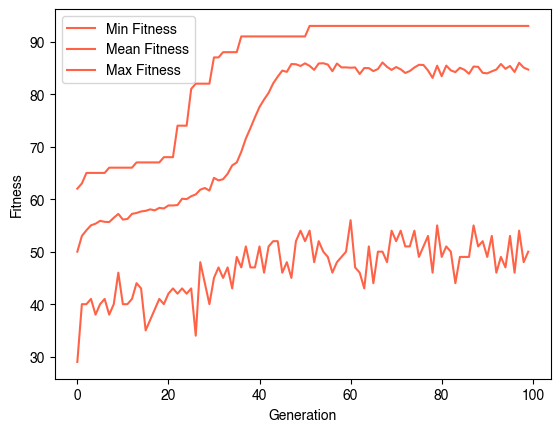

In [140]:
digit_7 = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 1, 1, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
])

def fitness(trajectory):
    """
    A fitness function that rewards convergence to a target pattern

    Args:
        trajectory (array): A 2D array of integers representing the state of the CA at
            each time step of the simulation. Shape is (n_steps, nx, ny)

    Returns:
        float: A fitness score
    """
    final_state = trajectory[-1]            
    return np.sum(np.abs(digit_7 - final_state))

evolver = EvolveCA(10, 20, population_size=100, fitness_function=fitness, random_state=0, verbose=True,
                    mutation_rate=0.1, 
                    crossover_rate=0.8, 
                    fraction_elites=0.5
                    )
evolver.evolve(100)

plt.figure()
plt.plot(np.min(evolver.history, axis=1), label="Min Fitness")
plt.plot(np.mean(evolver.history, axis=1), label="Mean Fitness")
plt.plot(np.max(evolver.history, axis=1), label="Max Fitness")
plt.legend()
plt.xlabel("Generation")
plt.ylabel("Fitness")

Text(0.5, 1.0, 'Final state')

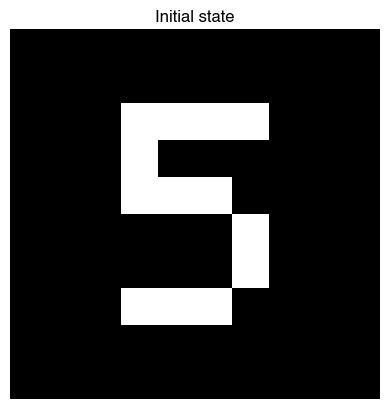

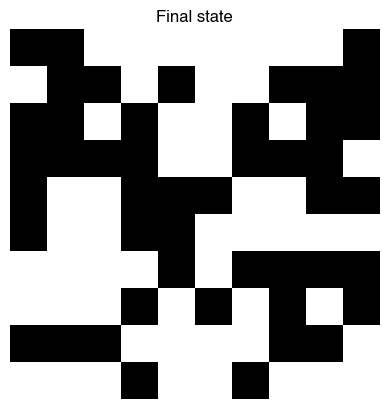

In [157]:
model = ProgrammaticCA(100, evolver.best_individual, random_state=0, initial_state=digit_5)
model.simulate(30)

plt.figure()
plt.imshow(model.initial_state, cmap="gray")
plt.axis("off")
plt.title("Initial state")


plt.figure()
plt.imshow(model.state, cmap="gray")
plt.axis("off")
plt.title("Final state")

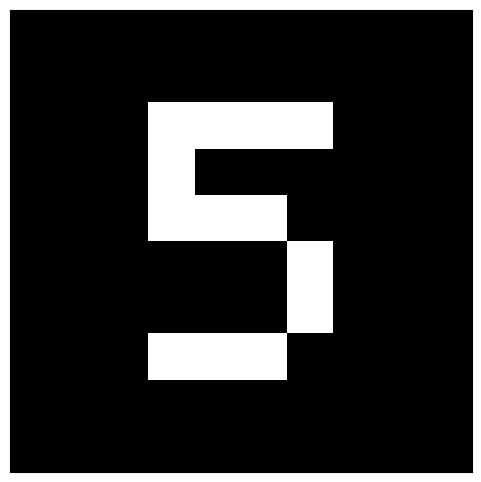

In [158]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Assuming frames is a numpy array with shape (num_frames, height, width)
frames = np.array(model.history).copy() 

fig = plt.figure(figsize=(6, 6))
img = plt.imshow(frames[0], vmin=0, vmax=1, cmap="gray");
plt.xticks([]); plt.yticks([])
# tight margins
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())

def update(frame):
    img.set_array(frame)

ani = FuncAnimation(fig, update, frames=frames, interval=200)
HTML(ani.to_jshtml())

## Outlook

Genetic algorithms can be found in many contexts where the "inverse" problem is difficult to solve. For example, they can be used to design meterials with desired properties, to optimize the design of mechanical structures like bridges, or even to perform hyperparameter optimization for machine learning models. In such case, one option is always to use brute force search, in which the system is simulated for every possible set of parameters. However, because this scales exponentially with the number of parameters, it is often infeasible to use this approach.

For example a recent study uses GA to design a metamaterial that exhibits nearly optimal optical absorption over a given wavelength range.

<img src="https://raw.githubusercontent.com/williamgilpin/cphy/main/resources/bossard_ga_metamaterial.png" style="max-width:40%; height:auto;">

Image from [Bossard et al. 2014](https://pubs.acs.org/doi/10.1021/nn4057148)

### Questions:

+ Our genetic algorithm includes several examples of *hyperparameters*, which are user-set parameters that control the behavior of the learning algorithm. What happens to our results if we change the the number of generations, crossover scheme, or the mutation rate?

+ We used Moore neighborhoods in our CA, in which a neighbor consists of the 8 cells surrounding a given cell, including the diagonals. Suppose we instead used a von Neumann neighborhood, in which a neighbor consists of the 4 cells surrounding a given cell, excluding the diagonals. How would you expect this to change the optimization problem's convergence rate and final results?

<br><br><br><br><br><br>

# Density classification

+ We now return to the problem of density classification:

+ Given a binary string of length $L$, we want to classify it as "high density" if the number of 1s is greater than $L/2$ and "low density" otherwise. This is an example of a *classification* problem, where we want to map an input to a discrete output.

+ When the original Crutchfield & Mitchell paper was published, the density classification problem specifically called for a CA that would map a length L binary string to a length L string containing a single class. For example,

$$
01000100101 \rightarrow 00000000000 \\
01010101000 \rightarrow 00000000000 \\
01010101011 \rightarrow 11111111111 \\
11101111011 \rightarrow 11111111111
$$

This was later shown to be *impossible* with a local CA.

Text(0, 0.5, 'Fraction correctly classified')

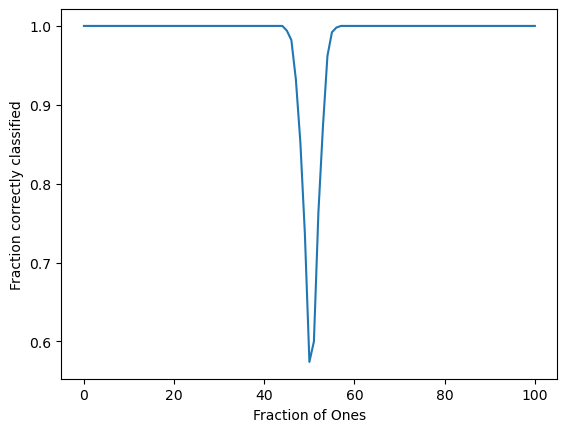

In [31]:
import warnings

def order_parameter_sweep(evaluator, l=101, nreps=50):
    """
    Perform a sweep over lattices of varying densities 

    Args:
        evaluator (callable): A function that takes a lattice as input and returns a 
            scalar order parameter
        l (int): The lattice size
        nreps (int): The number of repetitions for each order parameter value

    Returns:
        array: The order parameter values
    """
    if l % 2 == 0:
        warnings.warn("l should be odd for the order parameter to be well-defined. Adding 1 to l.")
        l += 1
    all_order_parameters = []
    for _ in range(nreps):
        lattice = np.zeros(l)
        score_values = []
        for i in range(l):
            output = evaluator(lattice)
            score_values.append(np.copy(output))

            ## select a random site with value 0 and update
            site = np.random.choice(np.where(lattice == 0)[0])
            lattice[site] = 1
        all_order_parameters.append(np.copy(np.array(score_values)))
    return np.array(all_order_parameters)

def kacs_model(lattice):
    """
    The Gács, Kurdyumov, and Levin heuristic

    Args:
        lattice (array): A 1D array of integers representing the lattice

    Returns:
        float: The order parameter
    """
    left1 = np.roll(lattice, 1) # left neighbor
    # left3 = np.roll(lattice, 3) # neighbor 3 sites to the left
    left3 = np.roll(lattice, -1) # neighbor 3 sites to the left
    total = lattice + left1 + left3
    return (total >= 2).astype(int)

def kacs_evaluator(lattice):
    true_majority = float(np.sum(lattice) > len(lattice) // 2)
    for _ in range(2 * len(lattice)):
        lattice = kacs_model(lattice)
    predicted_majority = float(np.sum(lattice) > len(lattice) // 2)
    return float(true_majority == predicted_majority)
    
order_params = order_parameter_sweep(kacs_evaluator, nreps=500)

plt.figure()
plt.plot(np.mean(order_params, axis=0))
plt.xlabel("Fraction of Ones")
plt.ylabel("Fraction correctly classified")

Text(0, 0.5, 'Fraction correctly classified')

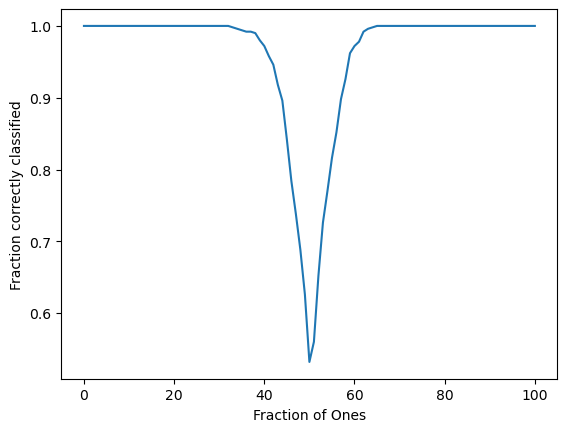

In [21]:
plt.figure()
plt.plot(np.mean(order_params, axis=0))
plt.xlabel("Fraction of Ones")
plt.ylabel("Fraction correctly classified")

Text(0, 0.5, 'Fraction correctly classified')

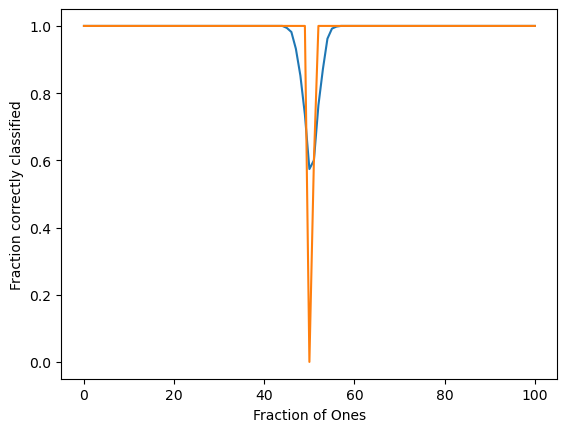

In [33]:
plt.figure()
plt.plot(np.mean(order_params, axis=0))
plt.plot(np.percentile(order_params, 40, axis=0))
plt.xlabel("Fraction of Ones")
plt.ylabel("Fraction correctly classified")

Text(0, 0.5, 'Fraction correctly classified')

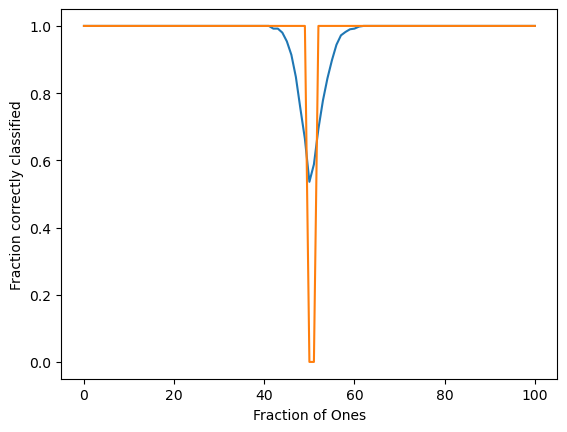

In [26]:
plt.figure()
plt.plot(np.mean(order_params, axis=0))
plt.plot(np.percentile(order_params, 40, axis=0))
plt.xlabel("Fraction of Ones")
plt.ylabel("Fraction correctly classified")

Text(0, 0.5, 'Fraction correctly classified')

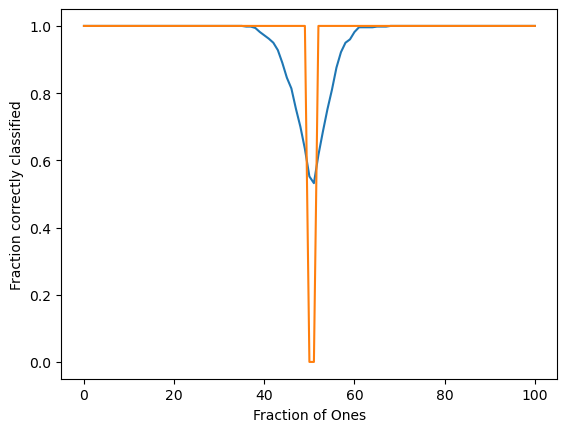

In [29]:
plt.figure()
plt.plot(np.mean(order_params, axis=0))
plt.plot(np.percentile(order_params, 40, axis=0))
plt.xlabel("Fraction of Ones")
plt.ylabel("Fraction correctly classified")